<a href="https://colab.research.google.com/github/CianOSull/AutoML_With_SA_FYP_2021/blob/AutoSklearn/MainNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generic Notebook for running all the libraries

How this notebook works is that it contains the code
for loading and cleaning the dataset.

Then there is multiple branches created on the
Github that include the code for running each library.

E.g. MLBox branch has the code for running MLBox.

# CURRENT BRANCH = AUTOSKLEARN

# Install the necessary library
Run the install code in the code cell below.

# Install 3 

From youtube: 

https://www.youtube.com/watch?v=0jXwYlX8wPk

Notebook:

https://github.com/bhattbhavesh91/auto-sklearn-tutorial/blob/master/autosklearn-classification.ipynb

In [1]:
!sudo apt-get install swig -y
!pip install Cython numpy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,284 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: 

In [2]:
!pip install pipelineprofiler

     |████████████████████████████████| 880kB 5.7MB/s 


In [18]:
!pip uninstall scikit-learn

Uninstalling scikit-learn-0.24.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-0.24.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-f7e03b3e.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-0.24.1


In [19]:
!pip install auto-sklearn

  Using cached https://files.pythonhosted.org/packages/f3/74/eb899f41d55f957e2591cde5528e75871f817d9fb46d4732423ecaca736d/scikit_learn-0.24.1-cp37-cp37m-manylinux2010_x86_64.whl


In [9]:
!pip install dask distributed --upgrade

Requirement already up-to-date: dask in /usr/local/lib/python3.7/dist-packages (2021.3.0)
Requirement already up-to-date: distributed in /usr/local/lib/python3.7/dist-packages (2021.3.0)


# Preprocessing Section

In [1]:
# Import the necessary modules for cleaning
import math
import time 
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Create the set of stopwords for cleaning text
stopwords = set(w.rstrip() for w in open('/content/drive/MyDrive/CIT/FYP/ImplementationFiles/stopwords.txt'))

In [3]:
# Download the necessary parts for the NLTK module
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# This funciton handles celaning text
def clean_text(text):
    # Create the lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Get rid of non alpha characters except "'" as it is needed for the lemment
    text = "".join(c for c in text if c.isalnum() or c == " " or "'")
    
    # Get rid of capitals
    text = text.lower()
    
    # Tokenize the words    
    # Create tokens of each word
    token_text = word_tokenize(text)
    
    # Get rid of any piece of text that isn't over 2 characters
    token_text = [t for t in token_text if len(t) > 2] 
    
    # Put words in base form by doing lemmatization
    token_text = [wordnet_lemmatizer.lemmatize(t) for t in token_text]

    # Remove stopwords
    token_text = [t for t in token_text if t not in stopwords]
    
    # Return the tokens
    return token_text

In [5]:
# This function will get the term frequencies for word in the review
# TF = Term I frequency in document/total words in document
def calc_tf(term_count, review_corpus):
    # A dictionary of all the term frequencies found
    tf_freq = dict.fromkeys(term_count.keys(), 0)   
    
    # Review corpus is a tokenized list so the total words iteh length
    total_words = len(review_corpus)
    
    # Calculate the term frequency for each word
    for word, count in term_count.items():
        tf_freq[word] = count/total_words
        
    return tf_freq

In [6]:
# This calcualtes the idf
# IDF = log(2)*(Total number of Documents/documents frequency or documents with term)
def calc_idf(unique_terms, list_doc_terms):   
    # A dicitonary of all the inverse document frequencies
    idf = dict.fromkeys(unique_terms, 0)
    
    # Basically list_doc_terms has all the documents with the term count for each word
    # You go through each document count the terms where they occured
    for doc_terms in list_doc_terms:  
        # This for loop is counting the amount of document a word was in
        for word, value in doc_terms.items():
            if 0 < value:
                idf[word] += 1
        
    # Now we calculate idf
    for word, value in idf.items():
        idf[word] = math.log10(10 / float(value))
    
    return idf

In [7]:
# Modified this function to return a list as dictionaries arn't needed anymore
def calc_tf_idf(tf, idf, n_terms):
    # Create an array that is of length of the number of unique terms
    tf_idf_array = np.zeros(n_terms)
    
    for index, (word, value) in enumerate(tf.items()):
        # Add the tfidf to the array
        tf_idf_array[index] = value*idf[word]
    
    return tf_idf_array

In [8]:
def process_text(text_data):
    # A list of all the cleaned reviews
    doc_list = []
    
    # List of all the unique terms
    unique_terms = []
    
    # A list of all the term frequencies
    tf_list = []
    
    for review in text_data:
        # First clean the review
        clean_review = clean_text(review)
        
        # Keeps track of the term counts for each word
        count_dict = {}
        
        # Now lets find the total count for each word
        for token in clean_review:
            if token not in count_dict:
                count_dict[token] = 1
            else:
                count_dict[token] += 1
        
        # Caclulate the term frequencies for each document
        tf_list.append(calc_tf(count_dict, clean_review))
        
        # Then add the dictionary of counts for each document to the list
        doc_list.append(count_dict)
        
        # Then add the new unique terms
        unique_terms = set(unique_terms).union(set(clean_review))
    
    # Calculate the inverse document frequency value
    idf = calc_idf(unique_terms, doc_list)
    
    # This array will contain the tfidf values for each term in each review
    tfidf_values = np.zeros((len(tf_list), len(unique_terms)))
    
    # Now we can get the TFIDF for each document
    for index, term_freq in enumerate(tf_list):
        # This will return an array of the tfidf values calculated.
        # The length of the unique terms list is passed in so that the 
        # Array that is returned matches the tfidf array
        tf_idf_array = calc_tf_idf(term_freq, idf, len(unique_terms))
        # Add this to the overall tfidf values calculated
        tfidf_values[index,:] = tf_idf_array
    
    return tfidf_values

In [9]:
# Prepare the data
def prepare_data(num):
    print("="*50)

    # Load the dataset
    # imdb_df = pd.read_csv("IMDB Dataset.csv")
    imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")
    print("Dataset loaded")
    print("="*50)

    
    # Change each positive and negative value to 1 and 0 respectively    
    imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})
    
    # For testing, a much smaller dataset is going to be used
    imdb_df = imdb_df.head(5000)

    # Group all the negative reviews and get the first 2500
    imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])[0:num]
    # Group all the positive and get the first 2500
    imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1][0:num]
    
    test_df = pd.concat([imdb_df_neg, imdb_df_pos]) 
    # print(test_df)
    
    # .values on a column of a dataframe returns a numpy array
    # This is a numpy array of all the reviews
    # initial_reviews = imdb_df['review'].values
    initial_reviews = test_df['review'].values
    
    # This is a numpy array of all the positive and negativelabels
    # labels = imdb_df['sentiment'].values
    labels = test_df['sentiment'].values
    
    print("Creating Feature Vector")
    print("="*50)
    start = time.time()
    # Process the text data and create teh feature vector
    feature_vector = process_text(initial_reviews)
    end = time.time()
    print("Feature Vector Created")
    print(f"Execution time is {end - start} secs")
    print("="*50)
    
    # Shuffle the labesl and feature vector using sklearn shuffle
    feature_vector, labels = shuffle(feature_vector, labels)
    
    # Creating train and test data
    # The splits will be 80:20 
    no_samples = 0.8
    
    # This gets the percentage of indexes from feature vector and uses those for training
    X_train = feature_vector[0:int(no_samples*len(feature_vector))]
    y_train = labels[0:int(no_samples*len(labels))]
    
    # Go from the index that was used for training to the final
    X_test = feature_vector[int(no_samples*len(feature_vector)):len(feature_vector)]
    y_test = labels[int(no_samples*len(labels)):len(labels)]

    return X_train, y_train, X_test, y_test

# Create model

In [10]:
import pandas as pd
import numpy as np
import PipelineProfiler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from autosklearn.classification import AutoSklearnClassifier

/usr/local/lib/python3.7/dist-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [11]:
# Prepare the data
X_train, y_train, X_test, y_test = prepare_data(500)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Dataset loaded
Creating Feature Vector
Feature Vector Created
Execution time is 5.787853002548218 secs


# AutoSklearn parameters:
https://automl.github.io/auto-sklearn/master/_modules/autosklearn/estimators.html

# Useful links

https://github.com/srivatsan88/YouTubeLI/blob/master/AutoSklearn.ipynb

https://www.youtube.com/watch?v=SMUNVfbr3Mc

https://automl.github.io/auto-sklearn/master/examples/20_basic/example_classification.html


# List of classificaiton estimators:
https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/classification

In [12]:
# This takes less than 10 seconds to run. Need to increase time parameters
# This will set it to run for 1 hour and only spend 6 minutes on each model
# n_jobs=X is a parameter that sets up multithreading
model = AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=3600, 
                              include_estimators=["gradient_boosting", "sgd"], exclude_estimators=None, 
                              include_preprocessors=["no_preprocessing"], exclude_preprocessors=None)
print("Finished defining model")

Finished defining model


In [13]:
model.fit(X_train, y_train)
print("Finished Fitting model")

[WARNING] [2021-03-24 20:36:40,522:Client-AutoML(1):a2818dbe-8ce0-11eb-828b-0242ac1c0002] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (3598.904829)
[WARNING] [2021-03-24 20:36:40,523:Client-AutoML(1):a2818dbe-8ce0-11eb-828b-0242ac1c0002] Capping the per_run_time_limit to 1799.0 to have time for a least 2 models in each process.
[WARNING] [2021-03-24 20:36:42,050:Client-AutoMLSMBO(1)::a2818dbe-8ce0-11eb-828b-0242ac1c0002] Configuration 363 not found
[WARNING] [2021-03-24 20:36:42,051:Client-AutoMLSMBO(1)::a2818dbe-8ce0-11eb-828b-0242ac1c0002] Configuration 199 not found
[WARNING] [2021-03-24 20:36:42,051:Client-AutoMLSMBO(1)::a2818dbe-8ce0-11eb-828b-0242ac1c0002] Configuration 548 not found
[WARNING] [2021-03-24 20:36:42,051:Client-AutoMLSMBO(1)::a2818dbe-8ce0-11eb-828b-0242ac1c0002] Configuration 596 not found
[WARNING] [2021-03-24 20:36:42,051:Client-AutoMLSMBO(1)::a2818dbe-8ce0-11eb-828b-0242ac1c0002]

# Get Metrics

In [18]:
# Most recent
y_pred = model.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

ValueError: ignored

In [65]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, y_pred)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[49 51]
 [47 53]]
True positives: 0.245 %
True negatives: 0.265 %
False positives: 0.235 %
False negatives: 0.255 %


In [68]:
true_positive = C[0,0]
true_negative = C[1,1]            
false_postiive = C[1,0]
false_negatives = C[0,1]

precision = true_positive/(true_positive+false_postiive)
recall = true_positive/(true_positive/false_negatives)

In [69]:
f1_score = (precision*recall)/(precision+recall)

print(f1_score)

0.5053589484327603


In [70]:
FPR = false_postiive/(false_postiive+true_negative)
print(FPR)

0.47


In [72]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fpr, tpr)

print("AUC:", auc)

AUC: 0.51


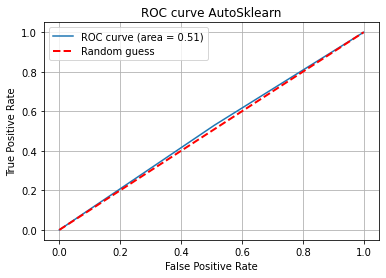

In [74]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve AutoSklearn')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Test model

In [ ]:
def test_dt():
  # Load the dataset
  nps_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.csv", encoding='utf8', engine='c')
  # imdb_df = pd.read_excel("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.xlsx")

  nps_df['sentiment'] = nps_df['sentiment'].map({'Negative' : 0, 'Positive' : 1})

  # Group all the negative reviews and get the first 25000
  # imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])[0:2500]
  nps_df_neg = (nps_df[nps_df['sentiment'] == 0])
  # Group all the positive and get the first 25000
  # imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"][0:2500]
  nps_df_pos = nps_df[nps_df['sentiment'] == 1]

  # Combine the two split positives and negatives into one dataframe
  nps_df = pd.concat([nps_df_neg, nps_df_pos]) 

  # .values on a column of a dataframe returns a numpy array
  # This is a numpy array of all the reviews
  initial_reviews = nps_df['test'].values
  print("Creating Feature Vector")
  print("="*50)
  start = time.time()
  # Process the text data and create teh feature vector
  feature_vector = process_text(initial_reviews)
  end = time.time()
  print("Feature Vector Created")
  print(f"Execution time is {end - start} secs")
  print("="*50)
  # print(feature_vector)

  # This is a numpy array of all the positive and negativelabels
  labels = nps_df['sentiment'].values

  # Shuffle the labesl and feature vector using sklearn shuffle
  feature_vector, labels = shuffle(feature_vector, labels)

  return feature_vector, labels 


In [ ]:
features, labels = test_dt()

# print(features)

y_pred = model.predict(features)
testing_accuracy = accuracy_score(labels, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

Creating Feature Vector
Feature Vector Created
Execution time is 0.48108744621276855 secs
Test Accuracy score 0.2096128170894526


# Outputting model

In [ ]:
# This is meant to be able to output the model
import pickle
x = automl.show_models()
results = {"ensemble": x}
pickle.dump(results, open('churn.pickle','wb'))

# =========================================================
# Old Results and should be ignored

In [23]:
# 21600 7200 Estimators and Preprocess off
y_pred = model.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

Test Accuracy score 0.435


In [ ]:
# 3600 1800 No Estimators and Preprocess on
y_pred = model.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

Test Accuracy score 0.532


In [ ]:
# 3600 1800 No Estimators and Preprocess on
y_pred = model.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

Test Accuracy score 0.492


In [ ]:
# This was done with tt = 3600 and pl = 360
y_pred = model.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

Test Accuracy score 0.492


In [ ]:
# Gives information and should show best model
model.cv_results_['params'][np.argmax(model.cv_results_['mean_test_score'])]

{'balancing:strategy': 'none',
 'classifier:__choice__': 'random_forest',
 'classifier:random_forest:bootstrap': 'True',
 'classifier:random_forest:criterion': 'gini',
 'classifier:random_forest:max_depth': 'None',
 'classifier:random_forest:max_features': 0.5,
 'classifier:random_forest:max_leaf_nodes': 'None',
 'classifier:random_forest:min_impurity_decrease': 0.0,
 'classifier:random_forest:min_samples_leaf': 1,
 'classifier:random_forest:min_samples_split': 2,
 'classifier:random_forest:min_weight_fraction_leaf': 0.0,
 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.01,
 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize',
 'featur

# ==============================================================

# Information about model
https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_get_pipeline_components.html#sphx-glr-examples-40-advanced-example-get-pipeline-components-py

In [ ]:
model.sprint_statistics()

'auto-sklearn results:\n  Dataset name: 41f0bf74-866b-11eb-8257-0242ac1c0002\n  Metric: accuracy\n  Number of target algorithm runs: 2599\n  Number of successful target algorithm runs: 0\n  Number of crashed target algorithm runs: 0\n  Number of target algorithms that exceeded the time limit: 0\n  Number of target algorithms that exceeded the memory limit: 2599\n'

In [ ]:
print(model.get_models_with_weights())

AttributeError: ignored

In [ ]:
model.get_params()

{'dask_client': None,
 'delete_output_folder_after_terminate': True,
 'delete_tmp_folder_after_terminate': True,
 'disable_evaluator_output': False,
 'ensemble_nbest': 50,
 'ensemble_size': 50,
 'exclude_estimators': None,
 'exclude_preprocessors': None,
 'get_smac_object_callback': None,
 'include_estimators': None,
 'include_preprocessors': None,
 'initial_configurations_via_metalearning': 25,
 'load_models': True,
 'logging_config': None,
 'max_models_on_disc': 50,
 'memory_limit': 3072,
 'metadata_directory': None,
 'metric': None,
 'n_jobs': None,
 'output_folder': None,
 'per_run_time_limit': 7200,
 'resampling_strategy': 'holdout',
 'resampling_strategy_arguments': None,
 'scoring_functions': None,
 'seed': 1,
 'smac_scenario_args': None,
 'time_left_for_this_task': 21600,
 'tmp_folder': None}

In [ ]:
print(model.show_models())

AttributeError: ignored